### K-means clustering for airport delay analysis using PCA (principal component analysis)

The operations of major airports across USA has been analysed from the data and the charatertics of departure and operational delays has been understood to be reported to the FAA govemerment.

The data for airport and flight delays has been averaged out from the year 2004 to 2014 and over the years the delays have increased. Data set has been taken from the FAA website. https://www.faa.gov/

We have reference few codes (PCA, dummy variable creation, K-means) from Mithers and Amit Dalal github notebooks. 
https://github.com/Mithers/Portfolio 
https://github.com/adalal80/GA-DSI

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Assumptions: few assumptions has been made by the FAA.
1. Diversions and Cancellations of flights are due to the weather conditions and those are not considered as operational delays.

2. Taxi out time (time taken by a flight to leave the gate) is a proportional to number of flights such that a higher number of flights will increase taxi out time, due to congestion in runways.

####  Airport dataset
Aiport - Airport Code

FAA Region - Which goverment region operates an airport

AP type - Airport type if its for commercial or federal use.

In [3]:
airport = pd.read_csv('C:/Users/Himanshu Ranjan/Downloads/dsp/New folder/airports.csv')
#Value count for AP Type - either public of federal, we want only public use
print (airport['AP Type'].value_counts())
#Use FAA Region as the variable to determine which region the airport is located
"""
AAL - Alaska
AEA – Eastern.
AGL – Great Lakes.
ANE – New England.
ANM – Northwest Mountain.
ASO – Southern.
ASW – Southwest.
AWP – Western Pacific.
"""
#we have created a new column as faa_regions which has unique FAA values and we convert it into numeric values.
i=0
aptype_dict = {}
for x in airport['FAA REGION'].unique():
    aptype_dict[x]=i
    i+=1
aptype_dict
airport['faa_region'] = airport['FAA REGION'].apply(lambda x: aptype_dict[x])
airport.sort_values('Airport').head(3)

Public Use                4857
Federalized/Commercial     288
Name: AP Type, dtype: int64


,Airport,AP_NAME,FAA REGION,CITY,STATE,AP Type,faa_region
2557,00A,TOTAL RF,AEA,BENSALEM,PA,Public Use,5
1791,00C,ANIMAS AIR PARK,ANM,DURANGO,CO,Public Use,6
4187,00F,BROADUS,ANM,BROADUS,MT,Public Use,6


### Airport Cancellations dataset 

Departure cancellation – when the flight is cancelled from a departing airport.

Arrival cancellation – when the flight is cancelled at arriving airport.

Departure diversion – flight departed are diverged due to some factors.

Arrival diversion -  when the arriving flight gets diverged.

In [4]:
cancel = pd.read_csv('C:/Users/Himanshu Ranjan/Downloads/dsp/New folder/airport_cancellations.csv')
cancel.head(2)

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004,242,235,71,46
1,ABQ,2005,221,190,61,33


### Airport Operation data set :
Departures – total departed aircrafts from an airport.

Arrivals - total arrived aircrafts at an airport.

Percentage of flights on time departures – no of flights departed on time/total no of flights departed

Percent of flights on time gate arrivals – no of flights arrived on time at the gate/total flights arrived.

Average taxi out time - The taxi-out time is defined as the time taken by a flight to leave the gate.

Average taxi out delay – (actual taxi out time - uncongested take off time)

Off block time - The estimated time at which the aircraft will commence movement.

In [5]:
ops = pd.read_csv('C:/Users/Himanshu Ranjan/Downloads/dsp/New folder/Airport_operations.csv')
ops.head()

#we have converted date type from string to date type.
ops['Year'] = pd.to_datetime(ops['Year'], format='%Y').dt.year
print ('Operations dataframe shape is:',ops.shape)

Operations dataframe shape is: (841, 15)


#### Merging Airports, Cancellation, and Operations Datasets on Airport and Year columns 

In [6]:
ops_cancel = pd.merge(ops,cancel,on=['Airport','Year'])
ops_cancel.iloc[:,[2,3,7,8,9,10,11,12,13,14,15,16,17,18]].head()

,departures,arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,53971,53818,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87,242,235,71,46
1,51829,51877,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24,221,190,61,33
2,49682,51199,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82,392,329,71,124
3,53255,53611,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71,366,304,107,45
4,49589,49512,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48,333,300,79,42


In [7]:
delays = pd.merge(airport,ops_cancel)

In [8]:
print (delays.shape)
print (delays.columns)
delays['Year'] = pd.to_datetime(delays['Year'], format='%Y').dt.year

(799, 25)
Index(['Airport', 'AP_NAME', 'FAA REGION', 'CITY', 'STATE', 'AP Type',
       'faa_region', 'Year', 'departures', 'arrivals',
       'percent on-time gate departures', 'percent on-time airport departures',
       'percent on-time gate arrivals', 'average_gate_departure_delay',
       'average_taxi_out_time', 'average taxi out delay',
       'average airport departure delay', 'average airborne delay',
       'average taxi in delay', 'average block delay',
       'average gate arrival delay', 'Departure Cancellations',
       'Arrival Cancellations', 'Departure Diversions', 'Arrival Diversions'],
      dtype='object')


#### Delay is the final dataset that we get after joining all three.

In [9]:
delays.head()

,Airport,AP_NAME,FAA REGION,CITY,STATE,AP Type,faa_region,Year,departures,arrivals,...,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,SJU,LUIS MUNOZ MARIN INTL,ASO,SAN JUAN,PR,Federalized/Commercial,0,2004,60371,56735,...,2.27,12.43,1.88,0.79,3.39,12.28,330,289,55,28
1,SJU,LUIS MUNOZ MARIN INTL,ASO,SAN JUAN,PR,Federalized/Commercial,0,2005,57736,54870,...,3.03,14.43,1.63,1.36,4.04,14.65,315,282,64,36
2,SJU,LUIS MUNOZ MARIN INTL,ASO,SAN JUAN,PR,Federalized/Commercial,0,2006,55707,52948,...,4.28,14.34,1.73,1.29,4.19,14.17,257,233,63,44
3,SJU,LUIS MUNOZ MARIN INTL,ASO,SAN JUAN,PR,Federalized/Commercial,0,2007,47987,47246,...,3.16,14.97,1.55,1.71,4.09,16.31,307,278,70,42
4,SJU,LUIS MUNOZ MARIN INTL,ASO,SAN JUAN,PR,Federalized/Commercial,0,2008,44493,43448,...,1.85,13.59,1.64,1.25,3.75,15.18,238,197,78,29


### Exploratory Data Analysis

In [10]:
#Plotted and Described the Data
delays.loc[:,'departures':].describe()

,departures,arrivals,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
count,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000
mean,113471.568210,113003.959950,0.779123,0.726958,0.766864,12.890250,13.872879,3.683292,15.703504,2.875532,1.414155,3.290826,13.428811,1299.314143,1341.068836,174.250313,170.256571
std,98059.144667,97705.308115,0.052279,0.076027,0.050502,3.036474,3.806217,2.337325,4.364217,1.169739,0.854702,0.989275,3.251647,1840.877193,1980.459892,172.638408,229.162686
min,731.000000,717.000000,0.529900,0.380800,0.513600,5.350000,7.240000,0.100000,6.290000,0.950000,0.020000,1.330000,6.330000,0.000000,0.000000,0.000000,0.000000
25%,42064.000000,42006.500000,0.753100,0.691800,0.742150,10.830000,11.475000,2.300000,12.890000,2.035000,0.845000,2.615000,11.270000,349.000000,314.500000,62.000000,41.000000
50%,79489.000000,79750.000000,0.784100,0.740200,0.770500,12.540000,12.940000,3.050000,15.130000,2.620000,1.140000,3.130000,12.970000,670.000000,653.000000,111.000000,84.000000
75%,166469.500000,165560.500000,0.810700,0.773700,0.797600,14.620000,15.745000,4.220000,17.555000,3.550000,1.775000,3.815000,14.935000,1483.500000,1542.000000,237.000000,190.000000
max,491826.000000,486799.000000,0.909700,0.897400,0.880300,25.840000,35.760000,18.940000,40.510000,7.820000,6.180000,7.520000,27.780000,16618.000000,17571.000000,1064.000000,1948.000000


#### Since no of departures from an airport varies significantly, we will average the departures for an airport and divide it into 3 catagories which will represent hue in the pairplot below

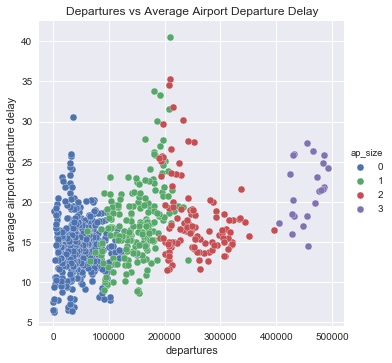

In [11]:
# we have implemented this code as the departure values was frequent and affecting the hue clusters, we have splitted the values at 100,000, 200,000, 350,000.
dep_air = delays.groupby('Airport')['departures'].mean().to_frame().sort_values('departures',ascending=False)
dep_air.reset_index(inplace = True)
size = []
for x in dep_air['departures']:
    if x >= 350000:
        size.append(3)
    elif (x< 350000) & (x>=200000):
        size.append(2)
    elif (x<200000) & (x>=100000):
        size.append(1)
    else:
        size.append(0)
dep_air['ap_size'] = size
delays = pd.merge(dep_air.iloc[:,0::2],delays)
sns.pairplot(x_vars = 'departures',y_vars ='average airport departure delay',data=delays,size=5,hue='ap_size');
plt.title("Departures vs Average Airport Departure Delay");

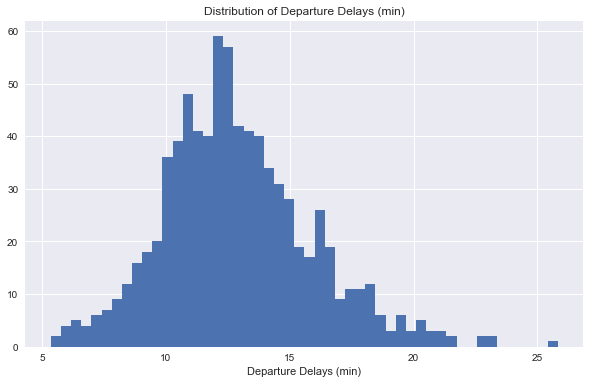

In [12]:
#average gate departure delay shows normal distribution
delays['average_gate_departure_delay'].hist(figsize = (10,6),bins = 50)
plt.title('Distribution of Departure Delays (min)')
plt.xlabel('Departure Delays (min)');

#### The next 3 graphs showas a positive linear relationship bettween the variables.

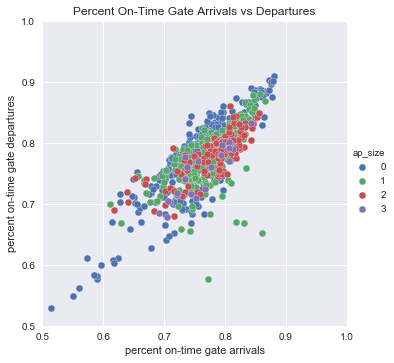

In [13]:
sns.pairplot(x_vars = 'percent on-time gate arrivals',y_vars ='percent on-time gate departures',data=delays,hue='ap_size',size=5)
plt.title('Percent On-Time Gate Arrivals vs Departures')
plt.xlim(.5,1)
plt.ylim(.5,1);

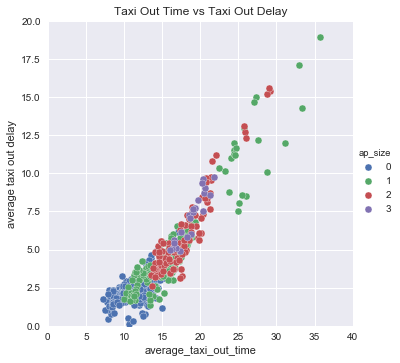

In [14]:
sns.pairplot(x_vars = 'average_taxi_out_time',y_vars ='average taxi out delay',data=delays,hue='ap_size',size=5)
plt.title('Taxi Out Time vs Taxi Out Delay')
plt.xlim(0,40)
plt.ylim(0,20);

#### When there is a gate arrival delay, it will cause the outgoing flights to run late due to congension in the platform. The regplot is used to visualize the linear relationship.

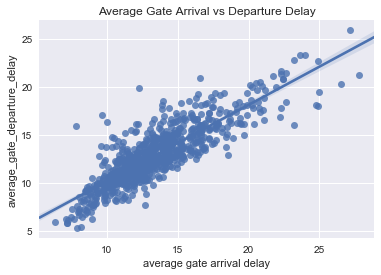

In [15]:
sns.regplot(x = 'average gate arrival delay',y ='average_gate_departure_delay',data=delays)
plt.title("Average Gate Arrival vs Departure Delay");

##### We are considering only the features which we think could be the reason for delay.

In [16]:
print (delays.columns)
col_to_use = ['departures','percent on-time gate departures','percent on-time airport departures','percent on-time gate arrivals',\
              'average_gate_departure_delay', 'average_taxi_out_time','average taxi out delay','average airport departure delay',\
              'average taxi in delay','average block delay','average gate arrival delay','Departure Cancellations',\
             'Arrival Diversions']

Index(['Airport', 'ap_size', 'AP_NAME', 'FAA REGION', 'CITY', 'STATE',
       'AP Type', 'faa_region', 'Year', 'departures', 'arrivals',
       'percent on-time gate departures', 'percent on-time airport departures',
       'percent on-time gate arrivals', 'average_gate_departure_delay',
       'average_taxi_out_time', 'average taxi out delay',
       'average airport departure delay', 'average airborne delay',
       'average taxi in delay', 'average block delay',
       'average gate arrival delay', 'Departure Cancellations',
       'Arrival Cancellations', 'Departure Diversions', 'Arrival Diversions'],
      dtype='object')


##### We are grouping the departures based on airports together and taking the average of all corresponding values.

In [17]:
df = delays.groupby('Airport')[col_to_use].mean().round(2)
df.reset_index(inplace = True)
classes = delays.groupby('Airport')['ap_size','faa_region'].mean()
classes.reset_index(inplace = True)
df = pd.merge(classes,df)
df.head(3)

,Airport,ap_size,faa_region,departures,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average taxi in delay,average block delay,average gate arrival delay,Departure Cancellations,Arrival Diversions
0,ABQ,0,2,44830.45,0.80,0.78,0.79,10.96,10.21,2.32,12.53,0.96,2.34,11.31,281.55,51.82
1,ANC,0,9,67627.55,0.80,0.77,0.78,14.77,12.32,1.98,16.01,0.58,4.80,15.68,277.55,43.09
2,ATL,3,0,469004.00,0.77,0.63,0.77,13.48,19.77,7.78,20.07,3.59,4.20,14.54,6562.36,872.18


#### Finding correlations in the data

In [18]:
df.iloc[:,4:].corr()

,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average taxi in delay,average block delay,average gate arrival delay,Departure Cancellations,Arrival Diversions
percent on-time gate departures,1.000000,0.799454,0.793907,-0.903089,-0.179868,-0.207913,-0.736153,-0.146895,-0.332774,-0.696822,-0.161425,-0.143281
percent on-time airport departures,0.799454,1.000000,0.665344,-0.834725,-0.696924,-0.746397,-0.956871,-0.531631,-0.583055,-0.750526,-0.498321,-0.465438
percent on-time gate arrivals,0.793907,0.665344,1.000000,-0.818072,-0.218377,-0.237015,-0.683127,-0.003437,-0.461706,-0.910382,-0.049849,0.022342
average_gate_departure_delay,-0.903089,-0.834725,-0.818072,1.000000,0.388308,0.383217,0.886382,0.269237,0.502782,0.862127,0.297389,0.231053
average_taxi_out_time,-0.179868,-0.696924,-0.218377,0.388308,1.000000,0.943421,0.737921,0.726400,0.678476,0.483566,0.605782,0.578116
average taxi out delay,-0.207913,-0.746397,-0.237015,0.383217,0.943421,1.000000,0.766257,0.712441,0.575567,0.486519,0.650204,0.614672
average airport departure delay,-0.736153,-0.956871,-0.683127,0.886382,0.737921,0.766257,1.000000,0.542127,0.629415,0.837593,0.531967,0.469378
average taxi in delay,-0.146895,-0.531631,-0.003437,0.269237,0.726400,0.712441,0.542127,1.000000,0.505308,0.254396,0.826983,0.876254
average block delay,-0.332774,-0.583055,-0.461706,0.502782,0.678476,0.575567,0.629415,0.505308,1.000000,0.647645,0.429883,0.417886
average gate arrival delay,-0.696822,-0.750526,-0.910382,0.862127,0.483566,0.486519,0.837593,0.254396,0.647645,1.000000,0.315373,0.212705


### PCA Analysis

There seems to be multi-collinearity of the variables in this dataset and therefore PCA is needed to reduce the dimensionality and multi-collinearity.It is an exercise where the data is projected in a direction which maximises the variance. It aims at finding the maximum variance direction and project it into smaller subspace

In [19]:
df.head()

,Airport,ap_size,faa_region,departures,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average taxi in delay,average block delay,average gate arrival delay,Departure Cancellations,Arrival Diversions
0,ABQ,0,2,44830.45,0.80,0.78,0.79,10.96,10.21,2.32,12.53,0.96,2.34,11.31,281.55,51.82
1,ANC,0,9,67627.55,0.80,0.77,0.78,14.77,12.32,1.98,16.01,0.58,4.80,15.68,277.55,43.09
2,ATL,3,0,469004.00,0.77,0.63,0.77,13.48,19.77,7.78,20.07,3.59,4.20,14.54,6562.36,872.18
3,AUS,0,2,53456.00,0.79,0.77,0.75,11.89,11.56,2.27,13.44,1.06,2.88,13.93,474.27,70.00
4,BDL,0,8,45903.09,0.81,0.77,0.76,11.77,13.05,3.11,14.01,0.97,3.13,13.72,509.36,37.18


#### FAA Region Dummies - There might be similarities in terms of air traffic flow, such as in new york area airports, or north east in general so we create dummy variables for regions and can be used for our PCA analysis.

In [20]:
# code has been referenced. 
X = df[col_to_use]
X = X.iloc[:,1:-2]
dummies = pd.get_dummies(df.iloc[:,2:3],columns = ['faa_region'])
X = pd.concat([dummies,X],axis=1)
X.head()

,faa_region_0,faa_region_1,faa_region_2,faa_region_4,faa_region_5,faa_region_6,faa_region_7,faa_region_8,faa_region_9,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average taxi in delay,average block delay,average gate arrival delay
0,0,0,1,0,0,0,0,0,0,0.80,0.78,0.79,10.96,10.21,2.32,12.53,0.96,2.34,11.31
1,0,0,0,0,0,0,0,0,1,0.80,0.77,0.78,14.77,12.32,1.98,16.01,0.58,4.80,15.68
2,1,0,0,0,0,0,0,0,0,0.77,0.63,0.77,13.48,19.77,7.78,20.07,3.59,4.20,14.54
3,0,0,1,0,0,0,0,0,0,0.79,0.77,0.75,11.89,11.56,2.27,13.44,1.06,2.88,13.93
4,0,0,0,0,0,0,0,1,0,0.81,0.77,0.76,11.77,13.05,3.11,14.01,0.97,3.13,13.72


Standardizing data is neccessary as they are measured on different scales.
Robust Scaler removes the median and scales the data according to the quantile range and convert it into variance which are then stored to be used on later data using the transform method.

#### fit_transform fits the model with X and apply the dimensionality reduction on X.

In [21]:
# code has been referenced. 

data_lr = df.iloc[:,[1,3,4,-3,9,11]] 
#selecting ap_size,departures percent,on-time gate departures,average gate arrival delay,
#average taxi out delay	average taxi in delay
X_lr = data_lr.iloc[:,2:]
#robust scaler
X_lrscaled = pd.DataFrame(RobustScaler().fit_transform(X_lr),columns = X_lr.columns)
y = pd.concat([data_lr.iloc[:,:2],X_lrscaled],axis=1)
y.head()

,ap_size,departures,percent on-time gate departures,average gate arrival delay,average taxi out delay,average taxi in delay
0,0,44830.45,0.25,-0.551334,-0.317503,-0.157576
1,0,67627.55,0.25,0.861762,-0.502035,-0.618182
2,3,469004.00,-0.50,0.493129,2.645862,3.030303
3,0,53456.00,0.00,0.295877,-0.344640,-0.036364
4,0,45903.09,0.50,0.227971,0.111262,-0.145455


#### PCA is performed using Robust Scalar to scale the data and the number of components will be set to 2 as we are representing it in a 2D vector. 

In [22]:
# code has been referenced

components = 2
X_train_pca,X_test_pca,y_train_pca,y_test_pca = train_test_split(X,y,random_state = 77)
#using robustscalar to transforms
X_scaledpca = pd.DataFrame(RobustScaler().fit_transform(X),columns = X.columns)
X_scaledpca_train = pd.DataFrame(RobustScaler().fit_transform(X_train_pca),columns = X.columns)
X_scaledpca_test = pd.DataFrame(RobustScaler().fit_transform(X_test_pca),columns = X.columns)
#calling on PCA
pca = PCA()
pca1 = PCA()
pca2 = PCA()
#use fit_transform
X_trans = pca.fit_transform(X_scaledpca)
X_trans_train = pca1.fit_transform(X_scaledpca_train)
X_trans_test = pca2.fit_transform(X_scaledpca_test)

In [23]:
X_scaledpca.head()

,faa_region_0,faa_region_1,faa_region_2,faa_region_4,faa_region_5,faa_region_6,faa_region_7,faa_region_8,faa_region_9,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average taxi in delay,average block delay,average gate arrival delay
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.516129,0.50,-0.543496,-0.693267,-0.317503,-0.713795,-0.157576,-0.829268,-0.551334
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.25,0.387097,0.25,0.719138,-0.167082,-0.502035,0.241592,-0.618182,1.837398,0.861762
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.50,-1.419355,0.00,0.291632,1.690773,2.645862,1.356211,3.030303,1.186992,0.493129
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.387097,-0.50,-0.235294,-0.356608,-0.344640,-0.463967,-0.036364,-0.243902,0.295877
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.50,0.387097,-0.25,-0.275062,0.014963,0.111262,-0.307481,-0.145455,0.027100,0.227971


In [24]:
print (X.shape[1])
pd.DataFrame(X).head()

19


,faa_region_0,faa_region_1,faa_region_2,faa_region_4,faa_region_5,faa_region_6,faa_region_7,faa_region_8,faa_region_9,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average taxi in delay,average block delay,average gate arrival delay
0,0,0,1,0,0,0,0,0,0,0.80,0.78,0.79,10.96,10.21,2.32,12.53,0.96,2.34,11.31
1,0,0,0,0,0,0,0,0,1,0.80,0.77,0.78,14.77,12.32,1.98,16.01,0.58,4.80,15.68
2,1,0,0,0,0,0,0,0,0,0.77,0.63,0.77,13.48,19.77,7.78,20.07,3.59,4.20,14.54
3,0,0,1,0,0,0,0,0,0,0.79,0.77,0.75,11.89,11.56,2.27,13.44,1.06,2.88,13.93
4,0,0,0,0,0,0,0,1,0,0.81,0.77,0.76,11.77,13.05,3.11,14.01,0.97,3.13,13.72


#### PCA is an example of feature selection that pca 1 axis defines the maximi variance between the points and pca2 axis defines the direction that is orthogonal to the 1st component.

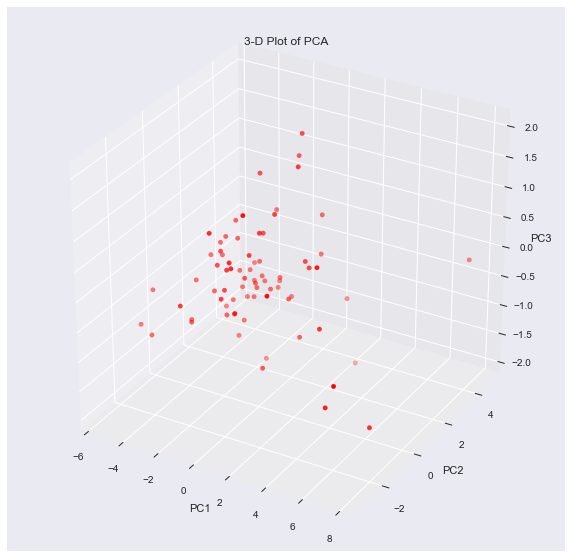

In [25]:
#we have used multiple sources to plot the below 3D graph for PCA.

from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components = 3)
X_trans3 = pca.fit_transform(X_scaledpca)
X_3d = pd.DataFrame(X_trans3, columns = ['PC1','PC2','PC3'])
threedee = plt.figure(figsize=(10,10)).gca(projection='3d')
threedee.scatter(X_3d['PC1'],X_3d['PC2'], X_3d['PC3'],color = 'red')
threedee.set_xlabel('PC1')
threedee.set_ylabel('PC2')
threedee.set_zlabel('PC3')
plt.title("3-D Plot of PCA")
plt.show()

In [26]:
X_scaledpca.describe()

,faa_region_0,faa_region_1,faa_region_2,faa_region_4,faa_region_5,faa_region_6,faa_region_7,faa_region_8,faa_region_9,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average taxi in delay,average block delay,average gate arrival delay
count,74.000000,74.00000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,7.400000e+01,7.400000e+01,74.000000,74.000000,7.400000e+01
mean,0.216216,0.22973,0.108108,0.040541,0.162162,0.054054,0.121622,0.054054,0.013514,-0.263514,-0.151700,-0.074324,0.081372,0.202939,4.050020e-01,1.365264e-01,0.376085,0.188823,1.201250e-01
std,0.414473,0.42353,0.312636,0.198569,0.371116,0.227668,0.329079,0.227668,0.116248,1.170332,0.892777,1.066881,0.875319,0.922630,1.168680e+00,1.080684e+00,0.944328,0.841056,8.972153e-01
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.250000,-2.709677,-4.750000,-2.107705,-1.197007,-9.036635e-01,-2.171585e+00,-0.824242,-1.219512,-1.602264e+00
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.750000,-0.612903,-0.500000,-0.379453,-0.367830,-3.107191e-01,-4.934798e-01,-0.242424,-0.379404,-5.286985e-01
50%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.205633e-16,2.437286e-16,0.000000,0.000000,-2.872052e-16
75%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.387097,0.500000,0.620547,0.632170,6.892809e-01,5.065202e-01,0.757576,0.620596,4.713015e-01
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.500000,1.806452,2.250000,3.078708,3.895262,4.930801e+00,3.497598e+00,3.745455,2.346883,3.089733e+00


#### Return an array of zeros with the same shape and type as a given array. Compute cluster centers and predict cluster index for each sample.
#### Using numer of components = 2, the KMeans cluster model gives the following cluster

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
  if sys.path[0] == '':


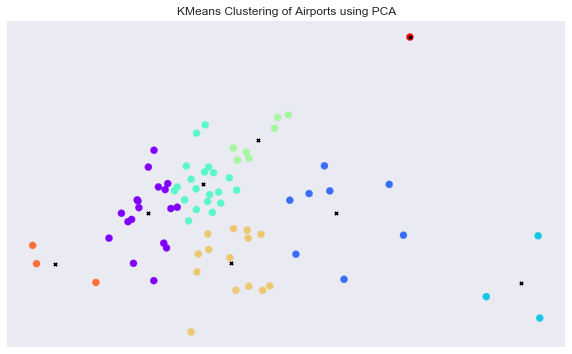

In [27]:
#we have used multiple sources to merge PCA and k-means clustering algorithms for analysis.

pca = PCA(n_components = 2)
X_trans = pca.fit_transform(X)
k = 8
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(X_trans)
centroids = kmeans.cluster_centers_
#fix permuted labels
from scipy import stats
labels = np.zeros_like(clusters)
for i in range(k):
    mask = (clusters == i)
    labels[mask] = stats.mode(y[mask])[0]
    
fig, ax = plt.subplots(figsize=(10,6))

plt.scatter(pd.DataFrame(X_trans).loc[:,0], pd.DataFrame(X_trans).loc[:,1], c=clusters,s=50, cmap='rainbow');
ax.set_xticks([]);
ax.set_yticks([]);

plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=10, linewidths=5,
            color='k', zorder=10)
plt.title('KMeans Clustering of Airports using PCA');

In [28]:
clusters_df = pd.DataFrame(clusters,columns=['cluster_label'])

#### We have performing a groupby on the cluster labels, using average of all the airports, gives us the airport count for each cluster.

In [29]:
X_cluster = pd.concat([clusters_df,df],axis=1)
X_cluster.sort_values('cluster_label',ascending=False)
cluster_count = X_cluster.groupby('cluster_label')['Airport'].count().to_frame("Airport Count")
cluster_count.reset_index(inplace = True)
cluster_count

,cluster_label,Airport Count
0,0,18
1,1,8
2,2,3
3,3,20
4,4,7
5,5,14
6,6,3
7,7,1


#### we have added the 'columns to use' and grouped it by cluster labels.

In [30]:
col_to_use2 = ['percent on-time gate departures','percent on-time airport departures','percent on-time gate arrivals',\
 'average_gate_departure_delay','average_taxi_out_time','average taxi out delay','average airport departure delay',\
 'average taxi in delay','average block delay','average gate arrival delay',]
cluster_groupby = X_cluster.groupby('cluster_label')[col_to_use2].mean().round(2)
cluster_groupby = cluster_groupby.rename(columns={"average_gate_departure_delay":'avg gate dep delay',"average_taxi_out_time":"avg taxi out time"})
cluster_groupby.reset_index(inplace = True)
pd.concat([cluster_count,cluster_groupby],axis=1)

,cluster_label,Airport Count,cluster_label,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,avg gate dep delay,avg taxi out time,average taxi out delay,average airport departure delay,average taxi in delay,average block delay,average gate arrival delay
0,0,18,0,0.80,0.78,0.78,10.86,11.30,2.39,12.45,0.93,2.74,11.70
1,1,8,1,0.76,0.67,0.74,15.40,17.72,5.64,20.04,2.27,3.99,16.11
2,2,3,2,0.74,0.54,0.70,16.73,25.95,11.65,27.03,2.68,4.92,19.76
3,3,20,3,0.78,0.74,0.76,13.07,12.12,2.78,15.05,1.06,2.92,13.49
4,4,7,4,0.73,0.70,0.72,15.74,12.46,2.67,17.71,0.89,3.81,15.72
5,5,14,5,0.79,0.72,0.80,11.93,16.06,4.59,15.54,2.08,3.38,11.70
6,6,3,6,0.88,0.87,0.85,7.12,10.04,1.71,7.89,0.87,3.13,8.58
7,7,1,7,0.58,0.54,0.58,21.89,13.82,3.39,24.57,1.35,4.87,22.57


#### we have plotted a reg plot for all the clusters we created and we see as the taxi time out increases against the clusters, the delay increases and hence the percent on-time airport departures decreases.

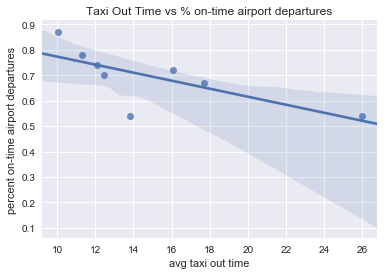

In [31]:
sns.regplot(data=cluster_groupby,x='avg taxi out time',y='percent on-time airport departures')
plt.title("Taxi Out Time vs % on-time airport departures");

### Cluster analysis and insights:
We have coded and analysed the results for three clusters only

In [32]:
X_cluster[X_cluster['cluster_label']==0]

,cluster_label,Airport,ap_size,faa_region,departures,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average taxi in delay,average block delay,average gate arrival delay,Departure Cancellations,Arrival Diversions
0,0,ABQ,0,2,44830.45,0.80,0.78,0.79,10.96,10.21,2.32,12.53,0.96,2.34,11.31,281.55,51.82
9,0,BUR,0,1,36536.82,0.80,0.78,0.79,10.45,11.04,2.20,11.93,0.63,2.10,10.82,428.27,40.64
28,0,ISP,0,5,10994.82,0.79,0.78,0.76,12.06,8.88,1.69,13.37,0.67,2.19,14.00,137.64,30.00
34,0,LGB,0,1,14980.55,0.84,0.82,0.81,9.28,13.37,2.41,10.64,0.97,3.30,10.72,100.82,51.55
43,0,MSY,0,2,49146.36,0.80,0.78,0.77,11.63,10.51,2.30,13.13,1.10,2.91,12.74,585.45,88.45
44,0,OAK,0,1,78622.73,0.78,0.75,0.78,11.06,10.12,2.20,12.67,1.00,2.26,11.14,670.64,55.09
51,0,PDX,1,6,101724.73,0.83,0.81,0.81,9.43,11.00,2.01,10.68,0.75,2.77,9.82,441.82,65.55
58,0,RFD,0,7,6708.00,0.73,0.71,0.76,12.39,9.56,1.31,13.40,0.41,3.01,11.96,3.17,4.00
59,0,RSW,0,0,34521.55,0.81,0.79,0.77,11.67,12.43,2.37,13.18,1.06,4.03,13.01,257.27,57.18
60,0,SAN,0,1,94522.18,0.82,0.77,0.79,10.31,13.28,3.53,12.76,0.97,2.70,11.44,1008.36,233.36


Cluster Label = 0: These airports vs those airports in cluster 2 are different in the fact that these have a higher departure delay. These airports are associated to Southwest region.

In [33]:
X_cluster[X_cluster['cluster_label']==1]

,cluster_label,Airport,ap_size,faa_region,departures,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average taxi in delay,average block delay,average gate arrival delay,Departure Cancellations,Arrival Diversions
2,1,ATL,3,0,469004.00,0.77,0.63,0.77,13.48,19.77,7.78,20.07,3.59,4.20,14.54,6562.36,872.18
7,1,BOS,1,8,174015.27,0.80,0.71,0.75,12.92,18.28,5.57,17.29,1.86,4.27,15.30,3087.36,141.18
21,1,FLL,1,0,108991.64,0.76,0.70,0.75,15.05,16.02,4.23,18.39,1.13,3.67,14.81,713.73,151.82
25,1,IAD,1,5,166881.27,0.74,0.67,0.75,16.57,17.02,4.65,20.41,1.54,3.14,15.37,2100.55,163.82
40,1,MIA,1,0,157204.09,0.74,0.69,0.74,17.29,16.17,3.49,19.95,2.55,4.00,16.25,955.09,190.09
48,1,ORD,3,7,441830.91,0.73,0.63,0.75,17.38,17.82,6.51,22.93,3.59,4.45,17.71,10892.00,769.09
52,1,PHL,2,5,222674.91,0.74,0.60,0.73,15.82,20.10,8.33,23.18,2.07,4.13,17.04,1994.91,279.64
64,1,SFO,1,1,181885.00,0.76,0.70,0.72,14.68,16.62,4.52,18.08,1.83,4.06,17.88,2717.64,260.64


Cluster Label = 1: These three airports are all hubs for major airlines, and are close approximation to percent variables, taxi out delay, and average airport delay.

In [34]:
X_cluster[X_cluster['cluster_label']==2]

,cluster_label,Airport,ap_size,faa_region,departures,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average taxi in delay,average block delay,average gate arrival delay,Departure Cancellations,Arrival Diversions
20,2,EWR,2,5,201708.27,0.73,0.53,0.68,17.69,24.48,11.50,27.87,2.56,5.27,22.47,4241.91,480.45
30,2,JFK,1,5,191168.55,0.74,0.55,0.72,17.20,28.61,11.46,27.43,3.19,4.91,18.35,2486.55,400.09
33,2,LGA,1,5,185804.91,0.76,0.54,0.71,15.31,24.76,11.99,25.78,2.29,4.58,18.47,4605.73,517.36


Cluster Label = 2: These airports are very close in range in percent on-time gate arrivals as well as avg gate departure delay.

#### Conclusion: The operational features are mostly correlated with delays are taxi out time (how long it takes from gate departure to take off) and the proximity of airports (more frequency of flights generally that are more congested).

#### Recommendation: If frequency of flights are high, it causes long taxi delays hence, FAA should invest in building more runways. This analysis could also be used for reducing the airline traffic while building new airports.